# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [2]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.1.2%2Bcu121-cp310-cp310-win_amd64.whl (4.0 MB)
  Using cached https://download.pytorch.org/whl/cu121/torch-2.1.2%2Bcu121-cp310-cp310-win_amd64.whl (2473.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.1.2
    Uninstalling torch-2.1.2:
      Successfully uninstalled torch-2.1.2
Note: you may need to restart the kernel to use updated packages.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [13]:
# First, lets load the dataset
data_train = dset.SVHN('data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]),download=True)
data_test = dset.SVHN('data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]),download=True)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [14]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [23]:
for _, (x, y) in enumerate(val_loader):
    print(y)
    print("----------------------")

tensor([1, 2, 1, 2, 2, 2, 2, 1, 7, 4, 5, 2, 1, 9, 7, 7, 6, 1, 6, 4, 6, 1, 1, 7,
        2, 4, 2, 0, 1, 8, 7, 0, 5, 9, 1, 0, 1, 6, 5, 1, 4, 0, 0, 1, 7, 1, 4, 7,
        8, 3, 2, 6, 7, 8, 9, 7, 6, 6, 1, 8, 2, 0, 0, 4])
----------------------
tensor([4, 7, 5, 2, 7, 9, 5, 9, 7, 9, 2, 1, 8, 2, 1, 2, 1, 3, 1, 6, 1, 1, 6, 0,
        2, 2, 6, 2, 0, 1, 1, 1, 8, 6, 7, 5, 5, 6, 5, 1, 6, 0, 3, 7, 1, 6, 8, 7,
        0, 2, 6, 2, 2, 1, 8, 1, 6, 4, 4, 4, 1, 3, 6, 7])
----------------------
tensor([4, 0, 2, 5, 2, 2, 1, 5, 8, 6, 2, 0, 6, 1, 1, 0, 1, 6, 7, 7, 8, 5, 6, 2,
        5, 9, 6, 7, 3, 8, 5, 3, 0, 4, 5, 1, 0, 2, 1, 9, 1, 7, 1, 5, 2, 3, 0, 8,
        3, 4, 0, 1, 6, 6, 4, 3, 5, 9, 1, 2, 6, 2, 6, 5])
----------------------
tensor([1, 2, 4, 6, 8, 7, 2, 7, 4, 4, 1, 1, 2, 4, 2, 7, 3, 3, 2, 9, 8, 8, 3, 9,
        1, 4, 3, 2, 1, 7, 2, 7, 6, 6, 7, 4, 0, 4, 4, 4, 2, 4, 3, 2, 6, 7, 0, 4,
        1, 9, 2, 5, 2, 8, 7, 7, 1, 8, 6, 2, 7, 2, 1, 3])
----------------------
tensor([1, 1, 3, 1, 1, 8, 3, 2, 8, 4, 3,

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [18]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [16]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [28]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        # val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    
    model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during 
    training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. You need to turn them off 
    during model evaluation, and .eval() will do it for you. In addition, the common practice for evaluating/validation is using 
    torch.no_grad() in pair with model.eval() to turn off gradients computation:
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    with torch.no_grad():
        correct_samples = 0
        total_samples = 0
        for _, (x, y) in enumerate(loader):
            prediction = model(x)
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
        accuracy = float(correct_samples) / total_samples
    
    return accuracy

# true_labels = 0
#     prediction_size = prediction.shape[0]
#     for i in range(prediction_size):
#         if prediction[i] == ground_truth[i]:
#             true_labels +=1
#     accuracy = true_labels / prediction_size


loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.318476, Train accuracy: 0.649456, Val accuracy: 0.640229
Average loss: 1.314552, Train accuracy: 0.650821, Val accuracy: 0.645212
Average loss: 1.313637, Train accuracy: 0.652305, Val accuracy: 0.645826


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [29]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.175954, Train accuracy: 0.201106, Val accuracy: 0.228517
Average loss: 1.993843, Train accuracy: 0.292223, Val accuracy: 0.345369
Average loss: 1.779894, Train accuracy: 0.389943, Val accuracy: 0.410279
Average loss: 1.700697, Train accuracy: 0.421578, Val accuracy: 0.428981
Average loss: 1.677751, Train accuracy: 0.434461, Val accuracy: 0.444270


In [30]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.830580, Train accuracy: 0.411050, Val accuracy: 0.531022
Average loss: 1.457545, Train accuracy: 0.582585, Val accuracy: 0.606580
Average loss: 1.378287, Train accuracy: 0.619373, Val accuracy: 0.633540
Average loss: 1.349655, Train accuracy: 0.634099, Val accuracy: 0.635042
Average loss: 1.334561, Train accuracy: 0.641794, Val accuracy: 0.638318


Добавьте слой с Batch Normalization

In [31]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.085060, Train accuracy: 0.308706, Val accuracy: 0.456010
Average loss: 1.768867, Train accuracy: 0.489540, Val accuracy: 0.536755
Average loss: 1.628037, Train accuracy: 0.551735, Val accuracy: 0.592110
Average loss: 1.541296, Train accuracy: 0.585042, Val accuracy: 0.624053
Average loss: 1.485023, Train accuracy: 0.608214, Val accuracy: 0.629172


In [32]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.105544, Train accuracy: 0.301181, Val accuracy: 0.428708
Average loss: 1.866228, Train accuracy: 0.448657, Val accuracy: 0.498533
Average loss: 1.786066, Train accuracy: 0.493721, Val accuracy: 0.500307
Average loss: 1.754437, Train accuracy: 0.517114, Val accuracy: 0.531500
Average loss: 1.742832, Train accuracy: 0.521517, Val accuracy: 0.537574


In [37]:
lambda1 = lambda epoch: epoch // 2
lm2 = lambda epoch: 0.95 **epoch
epoch = 10
print(lambda1(epoch))

5


Добавьте уменьшение скорости обучения по ходу тренировки.

In [43]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!


def train_model_annealing(model, train_loader, val_loader, loss, optimizer, num_epochs, step, gamma_):    
    loss_history = []
    train_history = []
    val_history = []
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma = gamma_)
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        scheduler.step()
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        # val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history



nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model_annealing(nn_model, train_loader, val_loader, loss, optimizer, 10, 2, 1e-1)

Average loss: 2.053164, Train accuracy: 0.312903, Val accuracy: 0.429732
Average loss: 1.852437, Train accuracy: 0.425707, Val accuracy: 0.447956
Average loss: 1.829433, Train accuracy: 0.439716, Val accuracy: 0.460037
Average loss: 1.815758, Train accuracy: 0.446780, Val accuracy: 0.462562
Average loss: 1.812423, Train accuracy: 0.449271, Val accuracy: 0.458740
Average loss: 1.812294, Train accuracy: 0.448469, Val accuracy: 0.458262
Average loss: 1.811575, Train accuracy: 0.450841, Val accuracy: 0.463859
Average loss: 1.811701, Train accuracy: 0.449988, Val accuracy: 0.461061
Average loss: 1.810606, Train accuracy: 0.450415, Val accuracy: 0.463313
Average loss: 1.811021, Train accuracy: 0.450227, Val accuracy: 0.455396


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [48]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    predictions = []
    ground_truth = []
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    sub = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset,
                                         sampler=sub)
    # raise Exception("Not implemented"
    with torch.no_grad():
        for _, (x, y) in enumerate(loader):
            prediction = model(x)
            _, indices = torch.max(prediction, 1)
            predictions.append(int(indices))
            ground_truth.append(int(y))
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

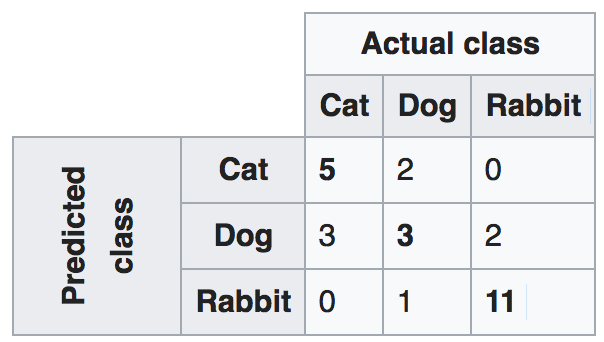

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

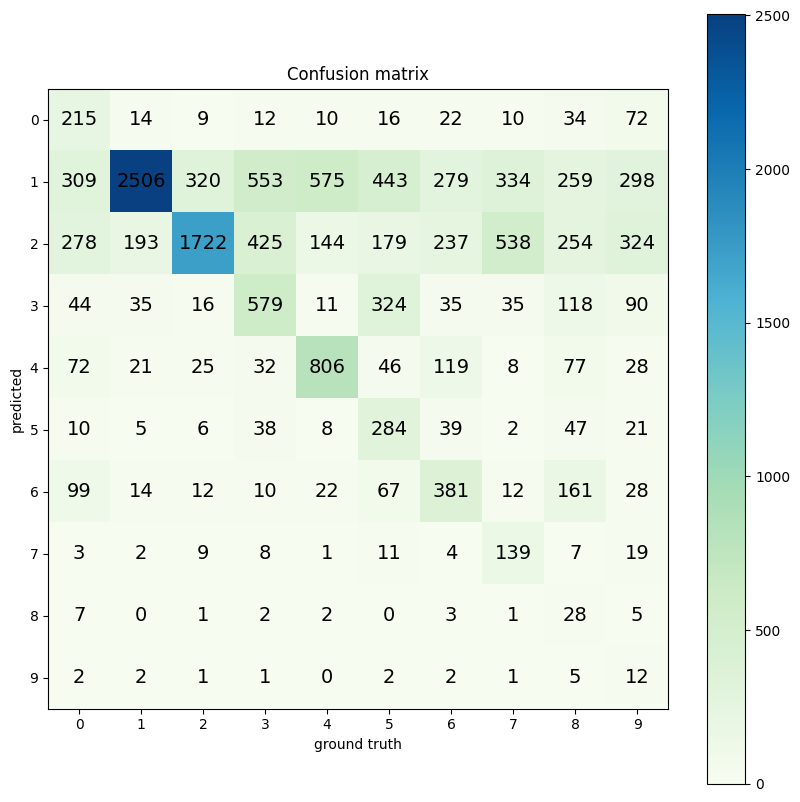

In [53]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    #number of classes
    n = len(np.unique(ground_truth))
    confussion_matrix = np.zeros((n,n), np.int_)

    for i in range(len(ground_truth)):
        confussion_matrix[predictions[i]][ground_truth[i]] +=1 
    # TODO: Implement filling the prediction matrix
    return confussion_matrix

confussion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confussion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

In [107]:
from torch.utils.data import DataLoader
data_train_images = dset.SVHN('data/', split='train',transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]), download=True)

Using downloaded and verified file: data/train_32x32.mat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


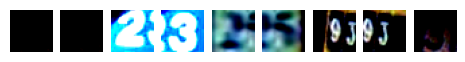

In [118]:
img_arr = []
plot_index=1
for i in range(0, 9):
    img, _ = data_train_images[i]
    img_arr.append(img)
for im in img_arr:
    plt.subplot(5, 10, plot_index)
    plt.imshow(im.permute(1, 2, 0))
    plt.axis('off')
    plot_index += 1

Using downloaded and verified file: data/train_32x32.mat


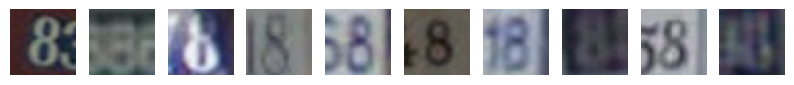

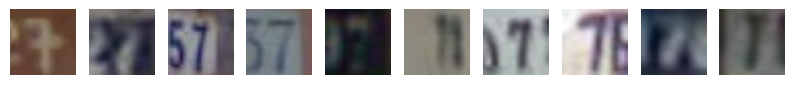

In [125]:
data_train_images2 = dset.SVHN('data/', split='train', download=True)
def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    # raise Exception("Not implemented")
    # print(predictions[:10])
    # print(groud_truth[:10])
    indices = []
    for index, label in enumerate(groud_truth):
        if (label == gt_class) and (predictions[index] == predicted_class):
            indices.append(val_indices[index])
    visualize_images(indices, data)
    # visualize_images(val_indices[np.logical_and(predicted_class == predictions, gt_class == groud_truth)], data)
    
    # print(predictions[val_indices[predicted_class==pred for pred in predictions]])
    # print(val_indices)
visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images2)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images2)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [129]:
# Experiment here!
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-2)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 20)

Average loss: 2.068239, Train accuracy: 0.302136, Val accuracy: 0.436489
Average loss: 1.697619, Train accuracy: 0.481674, Val accuracy: 0.547471
Average loss: 1.502320, Train accuracy: 0.564157, Val accuracy: 0.612996
Average loss: 1.369451, Train accuracy: 0.618623, Val accuracy: 0.657361
Average loss: 1.269392, Train accuracy: 0.651913, Val accuracy: 0.685482
Average loss: 1.191659, Train accuracy: 0.674573, Val accuracy: 0.704525
Average loss: 1.126878, Train accuracy: 0.694895, Val accuracy: 0.705754
Average loss: 1.070408, Train accuracy: 0.705679, Val accuracy: 0.726367
Average loss: 1.025900, Train accuracy: 0.716019, Val accuracy: 0.727664
Average loss: 0.984859, Train accuracy: 0.726120, Val accuracy: 0.729233
Average loss: 0.949690, Train accuracy: 0.736443, Val accuracy: 0.750939
Average loss: 0.916794, Train accuracy: 0.743337, Val accuracy: 0.760085
Average loss: 0.887141, Train accuracy: 0.750520, Val accuracy: 0.748959
Average loss: 0.860077, Train accuracy: 0.757090, V

In [130]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7720
